In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2 as cv
from tensorflow.keras.models import load_model
from utils import *

from sklearn.model_selection import train_test_split

C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [48]:
train_images = sorted(os.listdir('./data/train/be_enhanced'))
train_image = []
for im in train_images:
    img = image.load_img('./data/train/be_enhanced/'+ im, color_mode= 'rgb')
#     img = cv.imread('./data/train/be_enhanced/'+ im)
#     img = cv.resize(img, (256,256))
    img = image.img_to_array(img)
    img = img/255.0
    train_image.append(img)
train_df = np.array(train_image)

In [50]:
train_df.shape

(470, 400, 600, 3)

In [2]:
train_images = sorted(os.listdir('./data/train/be_enhanced'))
train_image = []
for im in train_images:
#     img = image.load_img('./data/train/be_enhanced/'+ im, color_mode= 'rgb')
    img = cv.imread('./data/train/be_enhanced/'+ im)
    img = cv.resize(img, (256,256))
    img = image.img_to_array(img)
    img = img/255.0
    train_image.append(img)
train_df_new = np.array(train_image)

In [3]:
train_df_new.shape

(470, 256, 256, 3)

In [4]:
train_images_name = []
for i in range(len(train_images)):
    temp = []
    temp.append(train_images[i].split('.')[0])
    temp.append(train_images[i].split('.')[1])
    train_images_name.append(temp)

In [5]:
train_images_name[0:5]

[['10', 'png'], ['100', 'png'], ['101', 'png'], ['102', 'png'], ['103', 'png']]

In [6]:
real_images = sorted(os.listdir('./data/train/high'))
real_image = []
for im in real_images:
#     img = image.load_img('./data/train/high/'+ im, color_mode= 'rgb')
    img = cv.imread('./data/train/high/'+ im)
    img = cv.resize(img, (256,256))
    img = image.img_to_array(img)
    img = img/255.0
    real_image.append(img)
real_df_new = np.array(real_image)

In [7]:
real_df_new.shape

(470, 256, 256, 3)

In [8]:
test_images = sorted(os.listdir('./data/test/be_enhanced'))
test_image = []
for im in test_images:
    img = image.load_img('./data/test/be_enhanced/'+ im, color_mode= 'rgb')
    img = image.img_to_array(img)
    img = img/255.0
    test_image.append(img)
test_df = np.array(test_image)

In [9]:
test_images_name = []
for i in range(len(test_images)):
    temp = []
    temp.append(test_images[i].split('.')[0])
    temp.append(test_images[i].split('.')[1])
    test_images_name.append(temp)

In [10]:
test_df.shape

(30, 400, 600, 3)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_df_new, real_df_new, test_size=0.25, random_state=42)

In [12]:
print('X_train --> {}'.format(X_train.shape))
print('X_test --> {}'.format(X_test.shape))
print('y_train --> {}'.format(y_train.shape))
print('y_test --> {}'.format(y_test.shape))

X_train --> (352, 256, 256, 3)
X_test --> (118, 256, 256, 3)
y_train --> (352, 256, 256, 3)
y_test --> (118, 256, 256, 3)


### Denoising Auto-Encoder

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

def autoencoder():

    Input_img = Input(shape=(256, 256, 3))  
    
    #encoding architecture
    x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x2 = MaxPool2D( (2, 2))(x2)
    encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

    # decoding architecture
    x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x3 = UpSampling2D((2, 2))(x3)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
    decoded = Conv2D(3, (3, 3), padding='same')(x1)

    # model
    autoencoder = Model(Input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [14]:
model= autoencoder()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 256)     7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 128)     295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 256, 256, 64)     

In [15]:
batch_size = 10
epoch = 50
# checkpoint_path = './dae_checkpoint2/cp-{epoch:04d}.ckpt'

In [16]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(x=X_train, y=X_train, epochs=epoch, batch_size=batch_size, validation_data=(X_test, X_test), callbacks=[early_stopping])

Epoch 1/50
36/36 [==============================] - 875s 24s/step - loss: 0.1396 - val_loss: 0.0193
Epoch 2/50
36/36 [==============================] - 822s 23s/step - loss: 0.0178 - val_loss: 0.0132
Epoch 3/50
36/36 [==============================] - 842s 23s/step - loss: 0.0087 - val_loss: 0.0079
Epoch 4/50
36/36 [==============================] - 822s 23s/step - loss: 0.0066 - val_loss: 0.0060
Epoch 5/50
36/36 [==============================] - 844s 23s/step - loss: 0.0054 - val_loss: 0.0045
Epoch 6/50
36/36 [==============================] - 848s 24s/step - loss: 0.0039 - val_loss: 0.0039
Epoch 7/50
36/36 [==============================] - 846s 24s/step - loss: 0.0036 - val_loss: 0.0042
Epoch 8/50
36/36 [==============================] - 846s 24s/step - loss: 0.0035 - val_loss: 0.0034
Epoch 9/50
36/36 [==============================] - 820s 23s/step - loss: 0.0032 - val_loss: 0.0033
Epoch 10/50
36/36 [==============================] - 853s 24s/step - loss: 0.0031 - val_loss: 0.0032

In [17]:
## Save the model

dae_checkpoint = './dae_checkpoint/dae_model.h5'
model.save(dae_checkpoint)

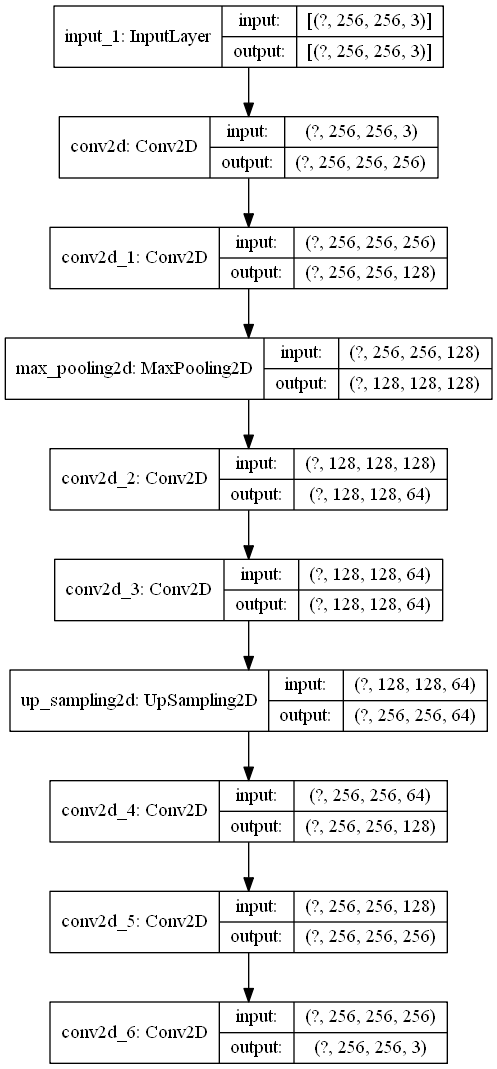

In [18]:
# Visualize model

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./preprocessing/dae_model_plot.png', show_shapes=True, show_layer_names=True)

In [63]:
# load the model and test
dae_checkpoint = './dae_checkpoint/dae_model.h5'
f_model = load_model(dae_checkpoint)

In [64]:

de_enhanced_path = './data/test/de_enhanced/'
for i in range(test_df.shape[0]):
    print('image -> [{}]'.format(i+1))
    pred_temp = f_model.predict(test_df[i:(i+1)])
    p_im = pred_temp[0,:,:,:]
    p_im = (p_im)*255
    p_im = np.clip(p_im, 0, 255)
    p_im = p_im.astype(np.uint8)
    p_im = cv.cvtColor(p_im, cv.COLOR_BGR2RGB)
    cv.imwrite(de_enhanced_path+test_images_name[i][0]+'.'+test_images_name[i][1], p_im)

image -> [1]
image -> [2]
image -> [3]
image -> [4]
image -> [5]
image -> [6]
image -> [7]
image -> [8]
image -> [9]
image -> [10]
image -> [11]
image -> [12]
image -> [13]
image -> [14]
image -> [15]
image -> [16]
image -> [17]
image -> [18]
image -> [19]
image -> [20]
image -> [21]
image -> [22]
image -> [23]
image -> [24]
image -> [25]
image -> [26]
image -> [27]
image -> [28]
image -> [29]
image -> [30]


In [65]:
test_high_data_name = glob(os.path.join('./data/test/high')+'/*.*')
enhanced_data_name = glob(os.path.join('./data/test/de_enhanced/')+'/*.*')

In [66]:
# Calculate psnr

psnr_scores = []
for idx in range(len(enhanced_data_name)):
    low_im = cv.imread(test_high_data_name[idx])
    enh_im = cv.imread(enhanced_data_name[idx])
    psnr_scores.append(psnr_score(low_im, enh_im))


# mean psnr
psnr_val = np.round(np.mean(psnr_scores), 3)
print('psnr value --> {}'.format(psnr_val))

psnr value --> 27.981


In [67]:
# Calculate ssim

ssim_scores = []
for idx in range(len(enhanced_data_name)):
    high_im = cv.imread(test_high_data_name[idx])
    enh_im = cv.imread(enhanced_data_name[idx])
    ssim_scores.append(ssim_score(high_im, enh_im))


# mean psnr
ssim_val = np.round(np.mean(ssim_scores), 4)
print('ssim value --> {}'.format(ssim_val))

ssim value --> 0.7277


In [68]:
# calculate brisque

brisque_scores = []
for idx in range(len(enhanced_data_name)):
    brisque_scores.append(brisque_score(enhanced_data_name[idx]))

# mean brisque
brisque_val = np.round(np.mean(brisque_scores), 4)
print('brisque value --> {}'.format(brisque_val))

brisque value --> 17.9741


#### Enhanced Images - Training Data

In [69]:
# load the model and test

f_model = load_model(dae_checkpoint)

de_enhanced_path = './data/train/de_enhanced/'
for i in range(train_df.shape[0]):
    print('image -> [{}]'.format(i+1))
    pred_temp = f_model.predict(train_df[i:(i+1)])
    p_im = pred_temp[0,:,:,:]
    p_im = (p_im)*255
    p_im = np.clip(p_im, 0, 255)
    p_im = p_im.astype(np.uint8)
    p_im = cv.cvtColor(p_im, cv.COLOR_BGR2RGB)
    cv.imwrite(de_enhanced_path+train_images_name[i][0]+'.'+train_images_name[i][1], p_im)

image -> [1]
image -> [2]
image -> [3]
image -> [4]
image -> [5]
image -> [6]
image -> [7]
image -> [8]
image -> [9]
image -> [10]
image -> [11]
image -> [12]
image -> [13]
image -> [14]
image -> [15]
image -> [16]
image -> [17]
image -> [18]
image -> [19]
image -> [20]
image -> [21]
image -> [22]
image -> [23]
image -> [24]
image -> [25]
image -> [26]
image -> [27]
image -> [28]
image -> [29]
image -> [30]
image -> [31]
image -> [32]
image -> [33]
image -> [34]
image -> [35]
image -> [36]
image -> [37]
image -> [38]
image -> [39]
image -> [40]
image -> [41]
image -> [42]
image -> [43]
image -> [44]
image -> [45]
image -> [46]
image -> [47]
image -> [48]
image -> [49]
image -> [50]
image -> [51]
image -> [52]
image -> [53]
image -> [54]
image -> [55]
image -> [56]
image -> [57]
image -> [58]
image -> [59]
image -> [60]
image -> [61]
image -> [62]
image -> [63]
image -> [64]
image -> [65]
image -> [66]
image -> [67]
image -> [68]
image -> [69]
image -> [70]
image -> [71]
image -> [72]
i

In [70]:
all_high_data_name = glob(os.path.join('./data/train/high')+'/*.*')
all_enhanced_data_name = glob(os.path.join('./data/train/de_enhanced/')+'/*.*')

In [71]:
# Calculate psnr

psnr_scores = []
for idx in range(len(all_enhanced_data_name)):
    high_im = cv.imread(all_high_data_name[idx])
    enh_im = cv.imread(all_enhanced_data_name[idx])
    psnr_scores.append(psnr_score(high_im, enh_im))


# mean psnr
psnr_val = np.round(np.mean(psnr_scores), 3)
print('psnr value --> {}'.format(psnr_val))

psnr value --> 28.129


In [72]:
# Calculate ssim

ssim_scores = []
for idx in range(len(all_enhanced_data_name)):
    high_im = cv.imread(all_high_data_name[idx])
    enh_im = cv.imread(all_enhanced_data_name[idx])
    ssim_scores.append(ssim_score(high_im, enh_im))


# mean psnr
ssim_val = np.round(np.mean(ssim_scores), 4)
print('ssim value --> {}'.format(ssim_val))

ssim value --> 0.6852


In [73]:
# calculate brisque

brisque_scores = []
for idx in range(len(all_enhanced_data_name)):
    brisque_scores.append(brisque_score(all_enhanced_data_name[idx]))

# mean brisque
brisque_val = np.round(np.mean(brisque_scores), 4)
print('brisque value --> {}'.format(brisque_val))

brisque value --> 20.042


### ExDark Dataset

In [74]:
exdark_images = sorted(os.listdir('./validation_data/ExDark/be_enhanced'))
exdark_image = []
for im in exdark_images:
    img = image.load_img('./validation_data/ExDark/be_enhanced/'+ im, color_mode= 'rgb')
    img = image.img_to_array(img)
    img = img/255
    exdark_image.append(img)
exdark_df = np.array(exdark_image)

In [75]:
exdark_df.shape

(100, 400, 600, 3)

In [76]:
exdark_images_name = []
for i in range(len(exdark_images)):
    temp = []
    temp.append(exdark_images[i].split('.')[0])
    temp.append(exdark_images[i].split('.')[1])
    exdark_images_name.append(temp)

In [77]:
exdark_images_name[0:5]

[['010013', 'jpg'],
 ['020015', 'jpg'],
 ['020462', 'jpg'],
 ['030101', 'jpg'],
 ['030295', 'jpg']]

In [78]:
# load the model and test

f_model = load_model(dae_checkpoint)

de_enhanced_path = './validation_data/ExDark/de_enhanced/'
for i in range(exdark_df.shape[0]):
    print('image -> [{}]'.format(i+1))
    pred_temp = f_model.predict(exdark_df[i:(i+1)])
    p_im = pred_temp[0,:,:,:]
    p_im = (p_im)*255
    p_im = np.clip(p_im, 0, 255)
    p_im = p_im.astype(np.uint8)
    p_im = cv.cvtColor(p_im, cv.COLOR_BGR2RGB)
    cv.imwrite(de_enhanced_path+exdark_images_name[i][0]+'.'+exdark_images_name[i][1], p_im)

image -> [1]
image -> [2]
image -> [3]
image -> [4]
image -> [5]
image -> [6]
image -> [7]
image -> [8]
image -> [9]
image -> [10]
image -> [11]
image -> [12]
image -> [13]
image -> [14]
image -> [15]
image -> [16]
image -> [17]
image -> [18]
image -> [19]
image -> [20]
image -> [21]
image -> [22]
image -> [23]
image -> [24]
image -> [25]
image -> [26]
image -> [27]
image -> [28]
image -> [29]
image -> [30]
image -> [31]
image -> [32]
image -> [33]
image -> [34]
image -> [35]
image -> [36]
image -> [37]
image -> [38]
image -> [39]
image -> [40]
image -> [41]
image -> [42]
image -> [43]
image -> [44]
image -> [45]
image -> [46]
image -> [47]
image -> [48]
image -> [49]
image -> [50]
image -> [51]
image -> [52]
image -> [53]
image -> [54]
image -> [55]
image -> [56]
image -> [57]
image -> [58]
image -> [59]
image -> [60]
image -> [61]
image -> [62]
image -> [63]
image -> [64]
image -> [65]
image -> [66]
image -> [67]
image -> [68]
image -> [69]
image -> [70]
image -> [71]
image -> [72]
i

In [79]:
val_enhanced_data_name = glob(os.path.join('./validation_data/ExDark/de_enhanced/')+'/*.*')

In [80]:
# calculate brisque

brisque_scores = []
for idx in range(len(val_enhanced_data_name)):
    brisque_scores.append(brisque_score(val_enhanced_data_name[idx]))

# mean brisque
brisque_val = np.round(np.mean(brisque_scores), 4)
print('brisque value --> {}'.format(brisque_val))

brisque value --> 33.3252
